In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm
import h5py
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, MaxPooling2D, Dense, Conv2D, Conv2DTranspose, Reshape, UpSampling2D, Layer, InputSpec, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint

In [3]:
import sklearn
from sklearn import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import decomposition
import scipy

#### Load data

Load data from ptychography simulation datasets from Panpan.

Also 2 other versions:
    crop the images to the central 32x32,
    crop the images to the central 64x64 and merged the adjacent cells resulting in 32x32

In [4]:
#change path to your location
pathToSimData="/home/drewp/Research/InPixelAI/simulated_data"

with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7.h5", "r") as f:
    dataFull = f['exchange/data'][...].real
with h5py.File(f"{pathToSimData}/data_cell_phase_n2e7_ref.h5", "r") as f:
    dataFull_ref = f['exchange/data'][...].real

print(dataFull.shape)
print(dataFull_ref.shape)

(1, 4488, 72, 72)
(1, 4488, 72, 72)


In [5]:
dataFull = dataFull.reshape(4488, 72, 72)
dataFull_ref = dataFull_ref.reshape(4488, 72, 72)

Flatten the data, and also make a version of the data that is log scale

In [6]:
dataFullFlat = dataFull.reshape(-1,72*72)
dataFullFlatLog = np.where(dataFullFlat>0,np.log2(dataFullFlat*2),0)
dataFullRefFlat = dataFull_ref.reshape(-1,72*72)
dataFullRefFlatLog = np.where(dataFullRefFlat>0,np.log2(dataFullRefFlat*2),0)

<ipython-input-6-ab538c910e4c>:2: RuntimeWarning: divide by zero encountered in log2
  dataFullFlatLog = np.where(dataFullFlat>0,np.log2(dataFullFlat*2),0)
<ipython-input-6-ab538c910e4c>:4: RuntimeWarning: divide by zero encountered in log2
  dataFullRefFlatLog = np.where(dataFullRefFlat>0,np.log2(dataFullRefFlat*2),0)


Determine which indices of diffraction patterns to graph

In [7]:
N = [4218, 1911, 2059, 2099, 2457, 1864]

# Modified baseline model
5184 -> 128 -> 5184, Linear activation

In [8]:
inputs = Input(shape=(5184),name='input')
encoder = Dense(128, activation="linear")
decoder = Dense(5184, activation="linear")

x = encoder(inputs)
x = decoder(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataFullFlat, dataFullFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5184)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               663680    
_________________________________________________________________
dense_1 (Dense)              (None, 5184)              668736    
Total params: 1,332,416
Trainable params: 1,332,416
Non-trainable params: 0
_________________________________________________________________


In [9]:
output = autoencoder.predict(dataFullRefFlat)
outputZS = np.where(output>0.5,output,0)

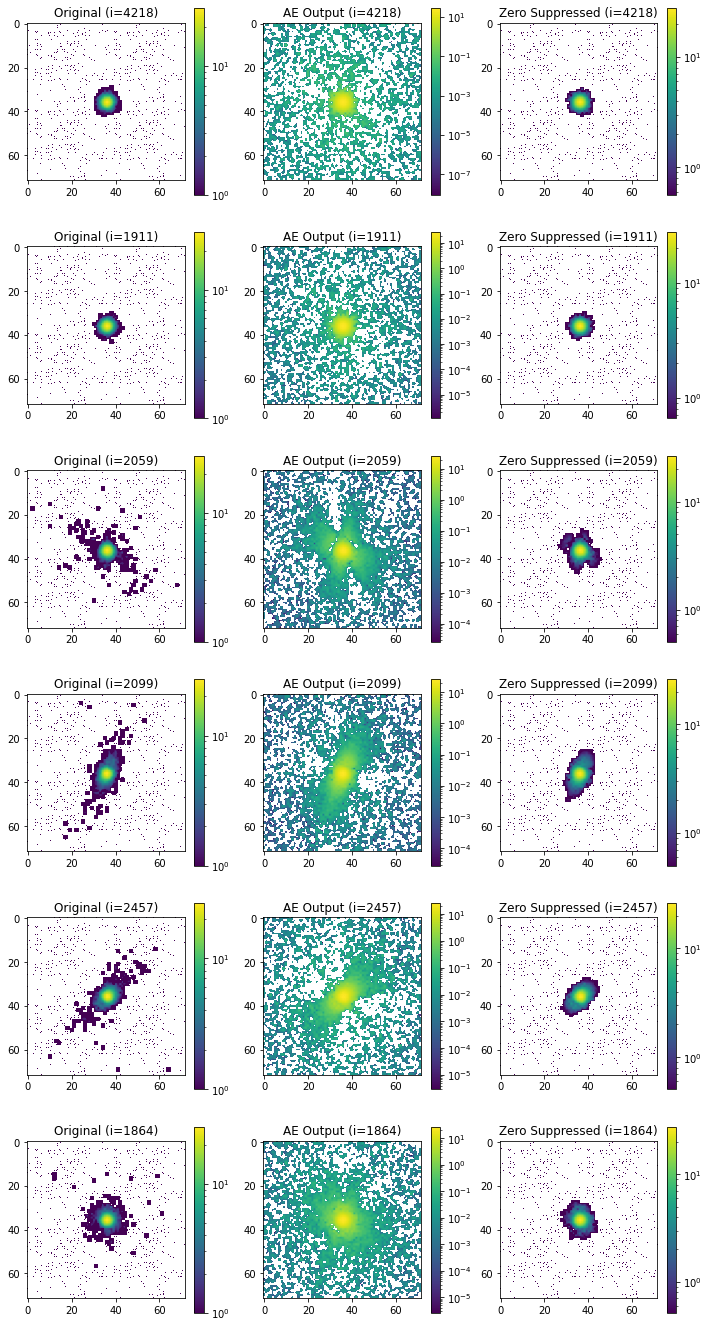

In [10]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataFullFlat[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')

plt.savefig("72x72_baseline.png")    

In [11]:
output_reshaped = output.reshape(1, 4488, 72, 72)
outputZS_reshaped = outputZS.reshape(1, 4488, 72, 72)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_72x72_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_72x72ZS_baseline.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)

# Modified ReLU model
5184 -> 1024 -> 128 -> 1024 -> 5184, ReLU activation

In [ ]:
inputs = Input(shape=(5184),name='input')
encoder1 = Dense(1024, activation="relu")
bn1 = BatchNormalization()
encoder2 = Dense(128, activation="relu")
bn2 = BatchNormalization()
decoder1 = Dense(1024, activation="relu")
bn3 = BatchNormalization()
decoder2 = Dense(5184, activation="relu")

x = encoder1(inputs)
x = bn1(x)
x = encoder2(x)
x = bn2(x)
x = decoder1(x)
x = bn3(x)
x = decoder2(x)

autoencoder = Model(inputs, x)
autoencoder.summary()
autoencoder.compile(metrics=['accuracy'],optimizer="adam", loss="mse")

autoencoder.fit(dataFullFlat, dataFullFlat,
                epochs=100,
                validation_split=.1,
                verbose=0
               )

output = autoencoder.predict(dataFullRefFlat)
outputZS = np.where(output>0.5,output,0)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 5184)]            0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              5309440   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              132096    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096

In [ ]:
output = autoencoder.predict(dataFullRefFlat)
outputZS = np.where(output>0.5,output,0)

In [ ]:
fig,ax = plt.subplots(len(N),3,figsize=(12,4*len(N)))

for i in range(len(N)):
    im = ax[i][0].imshow(dataFullFlat[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][0])
    ax[i][0].set_title(f'Original (i={N[i]})')
    
    im = ax[i][1].imshow(output[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][1])
    ax[i][1].set_title(f'AE Output (i={N[i]})')

    im = ax[i][2].imshow(outputZS[N[i]].reshape(72,72),norm=LogNorm())
    fig.colorbar(im,ax=ax[i][2])
    ax[i][2].set_title(f'Zero Suppressed (i={N[i]})')

plt.savefig("72x72_relu.png")     

In [ ]:
output_reshaped = output.reshape(1, 4488, 72, 72)
outputZS_reshaped = outputZS.reshape(1, 4488, 72, 72)
# in reconstruct_ptycho_PCA_dataset.py, need to change n_ls = ['...'] to the according name(s) e.g. ['test4'] for data_cell_phase_test4.h5
with h5py.File('data_cell_phase_72x72_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=output_reshaped,dtype=np.float32)
with h5py.File('data_cell_phase_72x72ZS_relu.h5','a') as f:
    f.create_dataset('exchange/data',data=outputZS_reshaped,dtype=np.float32)